# 5) Collocation Network

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Visualize word collocations as a network graph where nodes are words and edges are bigram co-occurrences.
- Identify hub words (high degree) that co-occur frequently with many other words.
- Filter edges by frequency threshold to focus on strong collocations and reveal phrase structure.

Learning objectives:
- Represent bigram data as a network graph using NetworkX.
- Compute and visualize largest connected components to see collocation clusters.
- Interpret node degree as a measure of word centrality in phrasal patterns.
- Use network visualization to explore stylistic and thematic phrase structure.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. Adjust `min_ngram_count` to control edge density (higher = sparser graph, clearer hubs).
3. (Optional) Toggle `use_stopwords` to remove function words and focus on content-word collocations.
4. Run cells from top to bottom. The main outputs are saved to `../results/`.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, networkx).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- Network graph: each word is a node; each bigram (a, b) creates an edge between nodes a and b weighted by co-occurrence count.
- Self-loops (edges from a word to itself) are filtered out for clarity.
- Largest connected component is extracted to avoid isolated word pairs cluttering the visualization.
- Node size scales with degree (number of connections); hub words appear larger.
- Edge width scales with weight (bigram count); frequent collocations appear thicker.
- Spring layout: positions nodes to minimize edge crossings and reveal structure.
- Consider removing stopwords first or filtering to content-words (nouns, verbs, adjectives) for cleaner networks.
- Compare per-book networks by running the same code on `text1` and `text2` separately to see shifts in collocation patterns.

**Goal:** Build and visualize a collocation network to explore phrase structure and identify hub words in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [6]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
   "book1_path": "../data/Crime-punishment.txt",  # <-- change
    "book2_path": "../data/The-Brotherskaramazov.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [7]:
# --- Boilerplate/front-matter stripper tuned for Dostoevsky releases ---------

_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants
]

_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Stronger start hints for these translations (Crime & Punishment / Brothers Karamazov)
_START_HINTS = [
    r"^\s*PART\s+[IVXLCDM0-9]+[\.\:\-\s]",    # PART I / PART 1
    r"^\s*BOOK\s+[IVXLCDM0-9]+[\.\:\-\s]",    # BOOK I / BOOK ONE
    r"^\s*CHAPTER\s+[IVXLCDM0-9]+[\.\:\-\s]", # CHAPTER I / CHAPTER 1
]

# End tails frequently used in these texts
_END_HINTS = [
    r"^\s*EPILOGUE\b.*",                      # EPILOGUE (we will keep epilogue but trim after END if present)
    r"^\s*THE\s+END\s*$",                     # THE END on its own line
    r"^\s*END OF (?:PART|BOOK|VOLUME)\s+[IVXLCDM0-9]+\s*$",
]

def _trim_to_first_hint(text: str, hints) -> str:
    for pat in hints:
        m = re.search(pat, text, flags=re.IGNORECASE | re.MULTILINE)
        if m:
            return text[m.start():]
    return text

def _trim_after_last_hint(text: str, hints) -> str:
    end_pos = None
    for pat in hints:
        for m in re.finditer(pat, text, flags=re.IGNORECASE | re.MULTILINE):
            end_pos = max(end_pos or 0, m.start())
    return text[:end_pos] if end_pos else text

def strip_gutenberg(text: str) -> str:
    """
    Return the main book body:
      1) Prefer explicit Gutenberg START/END markers.
      2) If missing, fall back to Dostoevsky-friendly chapter/part/book hints.
      3) Trim common tails like THE END / license blocks.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Try explicit Gutenberg markers first
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # No reliable GB markers → use stronger hints for these books
        core = _trim_to_first_hint(t, _START_HINTS)
        # If we still didn’t match, try very generic “chapter/book/part”
        if core is t:
            generic_hints = [
                r"^\s*chapter\s+[ivxlcdm0-9]+[\.\:\-\s]",
                r"^\s*book\s+[ivxlcdm0-9]+[\.\:\-\s]",
                r"^\s*part\s+[ivxlcdm0-9]+[\.\:\-\s]",
            ]
            core = _trim_to_first_hint(t, generic_hints)
        # Trim any tail markers if present
        core = _trim_after_last_hint(core, _END_HINTS)
        # And still remove GB license if it sneaks inside
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators, extra blank blocks
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)     # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)     # collapse big blank blocks
    return core.strip()


In [8]:
# --- helper so it works whether your notebook is in project root or in notebooks/ ---
def _path_in_data(fname: str) -> str:
    for p in (Path("./data")/fname, Path("../data")/fname):
        if p.exists():
            return str(p)
    raise FileNotFoundError(f"Couldn't find {fname} in ./data or ../data")

# Point to your dataset (exact filenames)
CONFIG["book1_path"] = _path_in_data("Crime-punishment.txt")
CONFIG["book2_path"] = _path_in_data("The-BrothersKaramazov.txt")

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 1.5) normalize curly quotes so contractions stay intact
    t = t.replace("’", "'").replace("‘", "'")
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Load + normalize both books
text1 = normalize_text(load_text(CONFIG["book1_path"]))   # Crime and Punishment
text2 = normalize_text(load_text(CONFIG["book2_path"]))   # The Brothers Karamazov

# Tokenize
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

# Optional stopword filtering
if CONFIG.get("use_stopwords", False):
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

# Combine if you need a pooled corpus
tokens = tokens1 + tokens2

# Quick sanity checks / preview
print("Book1 tokens:", len(tokens1), "| Book2 tokens:", len(tokens2), "| Combined:", len(tokens))
print("First 12 tokens (combined):", tokens[:12])


Book1 tokens: 205582 | Book2 tokens: 340440 | Combined: 546022
First 12 tokens (combined): ['part', 'i', 'chapter', 'i', 'chapter', 'ii', 'chapter', 'iii', 'chapter', 'iv', 'chapter', 'v']


## 2. Build Bigram Graph

- Nodes: words
- Edges: bigrams (weight = co-occurrence count)
- Filter edges by `min_ngram_count` for clarity


In [9]:
import networkx as nx
from collections import Counter
from itertools import tee, islice

def make_bigrams(tokens):
    """Yield adjacent token pairs (a,b) from a sequence."""
    a, b = tee(tokens)
    next(b, None)
    return zip(a, b)

def _is_empty_iterable(it):
    """Return True if iterable is empty without consuming more than one item."""
    it1, it2 = tee(it)
    first = next(it1, None)
    return True if first is None else False, it2 if first is None else (item for item in (first, *it1))

def build_bigram_graph(tokens, min_count=5, allow_self_loops=False):
    """
    Build an undirected weighted bigram graph from `tokens`.
    Returns: (G_full, G_largest_cc)
    """
    # Ensure tokens is an iterable we can traverse multiple times
    # (works for lists OR generators)
    tokens_iter = tokens if hasattr(tokens, "__iter__") else iter(tokens)

    # Fast exit for tiny inputs (need at least 2 tokens)
    # Check emptiness first
    empty, tokens_iter = _is_empty_iterable(tokens_iter)
    if empty:
        G = nx.Graph()
        return G, G

    # We need pairs; create a tee to see if there are at least 2 items
    t1, t2 = tee(tokens_iter)
    a, b = tee(t1)
    next(b, None)
    has_second = next(b, None) is not None
    if not has_second:
        G = nx.Graph()
        return G, G

    # Recreate tokens for counting after peeking
    tokens_for_counts, _ = tee(t2)
    bigram_counts = Counter(make_bigrams(tokens_for_counts))

    # Filter edges
    edges = []
    for (u, v), c in bigram_counts.items():
        if c < min_count:
            continue
        if not allow_self_loops and u == v:
            continue
        edges.append((u, v, c))

    # Build graph
    G = nx.Graph()
    for u, v, w in edges:
        if G.has_edge(u, v):
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)

    # Largest connected component for readability
    if G.number_of_nodes() > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        H = G.subgraph(largest_cc).copy()
    else:
        H = G

    return G, H

# --- choose which tokens you want to graph ---
# Combined corpus:
G_all, H_all = build_bigram_graph(tokens, min_count=CONFIG["min_ngram_count"])

# Per-book graphs (optional):
G_cnp, H_cnp = build_bigram_graph(tokens1, min_count=CONFIG["min_ngram_count"])  # Crime & Punishment
G_bk,  H_bk  = build_bigram_graph(tokens2, min_count=CONFIG["min_ngram_count"])  # Brothers Karamazov

# Quick sizes:
print("Combined:", G_all.number_of_nodes(), "→ LCC:", H_all.number_of_nodes())
print("C&P     :", G_cnp.number_of_nodes(), "→ LCC:", H_cnp.number_of_nodes())
print("BK      :", G_bk.number_of_nodes(),  "→ LCC:", H_bk.number_of_nodes())


Combined: 2993 → LCC: 2946
C&P     : 1454 → LCC: 1434
BK      : 2139 → LCC: 2102


## 3. Visualize Graph (spring layout)

## 3a. Filtered Network (Top Hubs Only)

For a clearer visualization, we aggressively filter to show only:
- **Top hub words** (highest degree nodes)
- **Strong connections** between these hubs only (edge weight ≥ 2× min_ngram_count)

This reveals the core collocation structure without overcrowding. You can adjust:
- `top_n_hubs` - how many hub words to show (default: 20)
- `min_edge_weight` - minimum connection strength to display (default: 2× min_ngram_count)

Filtered network: 50 nodes, 788 edges


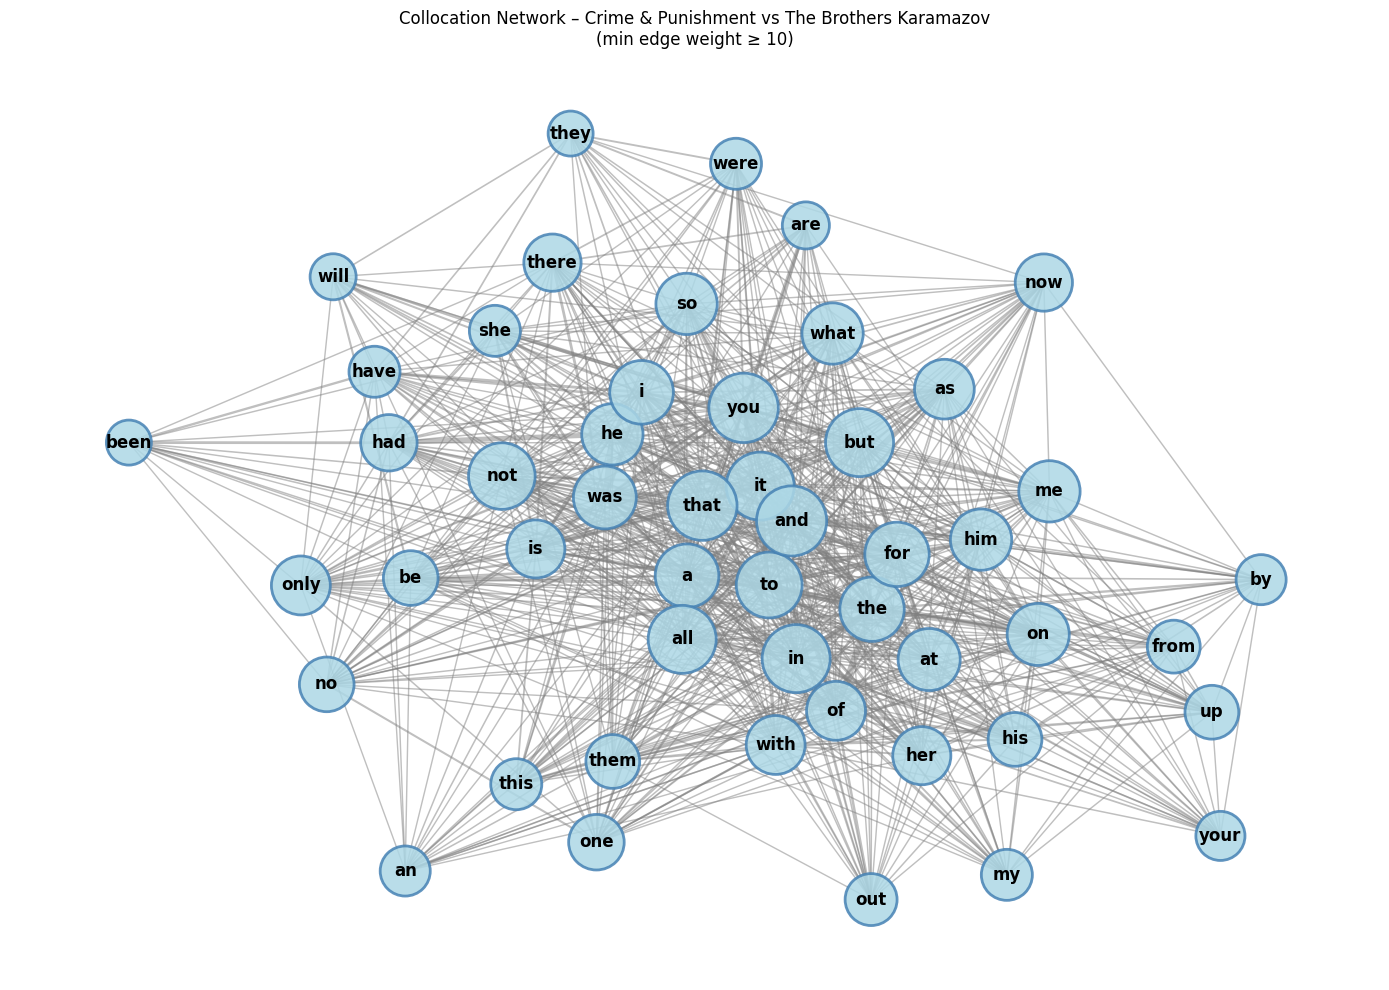

In [7]:
# Ensure H exists (e.g., after a kernel restart)
try:
    H  # noqa: F821
except NameError:
    # Fall back: build from combined tokens with your current threshold
    _, H = build_bigram_graph(tokens, min_count=CONFIG["min_ngram_count"])

# Strategy: Show only strongest edges between high-degree nodes
# This creates a much cleaner, more readable network

# 1. Select top hubs by degree
top_n_hubs = 50  # start with top 20 hub words
deg = dict(H.degree())
top_hubs = set(sorted(deg, key=deg.get, reverse=True)[:top_n_hubs])

# 2. Filter to only include edges between these hubs with strong connections
# Only keep edges where BOTH nodes are hubs AND edge weight is high
edge_weights = [(u, v, d['weight']) for u, v, d in H.edges(data=True)]
edge_weights.sort(key=lambda x: x[2], reverse=True)

# Keep only edges where both nodes are in top hubs and weight is above threshold
min_edge_weight = CONFIG["min_ngram_count"] * 2  # stricter threshold for cleaner graph
filtered_edges = [
    (u, v, w) for u, v, w in edge_weights
    if u in top_hubs and v in top_hubs and w >= min_edge_weight
]

# 3. Build clean filtered graph
H_filtered = nx.Graph()
for u, v, w in filtered_edges:
    H_filtered.add_edge(u, v, weight=w)

print(f"Filtered network: {H_filtered.number_of_nodes()} nodes, {H_filtered.number_of_edges()} edges")

# 4. Visualize - much cleaner now!
fig_filtered = plt.figure(figsize=(14,10))
pos = nx.spring_layout(H_filtered, k=0.8, iterations=100, seed=42)
deg_filtered = dict(H_filtered.degree())
wts_filtered = [H_filtered[u][v]["weight"] for u,v in H_filtered.edges()]

if wts_filtered and H_filtered.number_of_nodes() > 0:
    wmin, wmax = min(wts_filtered), max(wts_filtered)
    ew_filtered = [1 + 4*(w - wmin)/(wmax - wmin + 1e-9) for w in wts_filtered]

    # Draw nodes with size based on degree
    node_sizes = [200 + 50*deg_filtered[n] for n in H_filtered]
    nx.draw_networkx_nodes(
        H_filtered, pos, node_size=node_sizes, alpha=0.85,
        node_color='lightblue', edgecolors='steelblue', linewidths=2
    )
    nx.draw_networkx_edges(H_filtered, pos, width=ew_filtered, alpha=0.5, edge_color='gray')

    # Label all nodes - now readable!
    nx.draw_networkx_labels(H_filtered, pos, font_size=12, font_weight='bold')

    # Title reflecting your dataset
    plt.title(f"Collocation Network – Crime & Punishment vs The Brothers Karamazov\n(min edge weight ≥ {min_edge_weight})")
    plt.axis("off"); plt.tight_layout(); plt.show()
else:
    print(f"Graph too sparse. Try lowering min_edge_weight (currently {min_edge_weight}) or increase top_n_hubs.")


Can you now filter for stopwords and look again at the network?

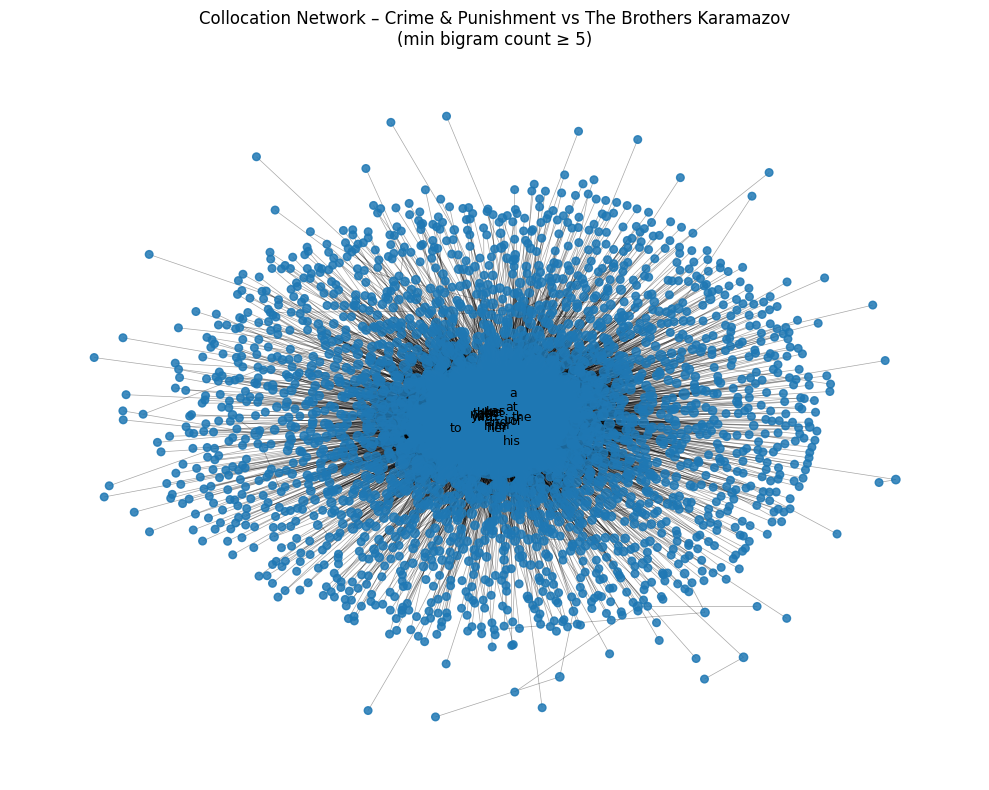

In [8]:
# Ensure H exists (in case kernel was restarted or cell order changed)
try:
    H  # noqa: F821
except NameError:
    # Build from your combined Dostoevsky tokens
    _, H = build_bigram_graph(tokens, min_count=CONFIG["min_ngram_count"])

# --- Visualization ---
fig_network = plt.figure(figsize=(10,8))
pos = nx.spring_layout(H, k=0.25, iterations=50, seed=42)
deg = dict(H.degree())
wts = [H[u][v]["weight"] for u, v in H.edges()]

if wts:
    wmin, wmax = min(wts), max(wts)
    ew = [0.5 + 2.5 * (w - wmin) / (wmax - wmin + 1e-9) for w in wts]
else:
    ew = []

nx.draw_networkx_nodes(H, pos, node_size=[24 + 6*deg[n] for n in H], alpha=0.85)
nx.draw_networkx_edges(H, pos, width=ew, alpha=0.35)

# Label a few hubs
top_nodes = sorted(deg, key=deg.get, reverse=True)[:20]
nx.draw_networkx_labels(H, pos, labels={n: n for n in top_nodes}, font_size=9)

# ✅ Updated title to match your dataset
plt.title(f"Collocation Network – Crime & Punishment vs The Brothers Karamazov\n(min bigram count ≥ {CONFIG['min_ngram_count']})")
plt.axis("off"); plt.tight_layout(); plt.show()


## 4. Notes

- Consider removing stopwords or filtering to content-words first.
- Compare per-book networks to see shifts in phrase structure.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

# Ensure results folder exists
Path("../results").mkdir(exist_ok=True)

# --- Save full network figure ---
try:
    fig_network.savefig("../results/collocation_network_full.png", dpi=200, bbox_inches="tight")
    print("Saved: collocation_network_full.png")
except NameError:
    print("⚠'fig_network' not defined — skipping full network save.")
except Exception as e:
    print(f"Could not save full network: {e}")

# --- Save filtered network figure (cleaner graph) ---
try:
    fig_filtered.savefig("../results/collocation_network_filtered.png", dpi=200, bbox_inches="tight")
    print("Saved: collocation_network_filtered.png")
except NameError:
    try:
        plt.savefig("../results/collocation_network_filtered.png", dpi=200, bbox_inches="tight")
        print("Saved filtered network using current active figure.")
    except Exception as e:
        print(f"Could not save filtered network: {e}")


⚠'fig_network' not defined — skipping full network save.
Saved filtered network using current active figure.


<Figure size 640x480 with 0 Axes>

In [ ]:
'''TIP RUN THE CONFIG , NORMAILIZE AND TOKENIZE AND THE BIGRAM AND THEN COMPLETE FROM HERE'''

In [10]:

# ===== Character Mention Extraction =====

from character_library import CHARACTERS
import re



def extract_character_mentions(text, character_dict):
    """
    Returns a list of character names (canonical forms)
    found in the text according to the character dictionary.
    """
    found = []
    text_lower = text.lower()

    for canonical, aliases in character_dict.items():
        for alias in aliases:
            # match whole words only
            pattern = r"\b" + re.escape(alias) + r"\b"
            if re.search(pattern, text_lower):
                found.append(canonical)
                break  # stop at first matching alias
    return found


In [11]:
import networkx as nx
from itertools import combinations
import re

def build_character_graph(text, character_dict):
    """
    Create an undirected weighted graph where nodes are characters
    and edges indicate co-occurrence within the same paragraph.
    """
    paragraphs = re.split(r'\n\s*\n', text)
    G = nx.Graph()

    for para in paragraphs:
        chars = extract_character_mentions(para, character_dict)
        for a, b in combinations(set(chars), 2):
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)
    return G


In [12]:
from character_library import CHARACTERS

# Build per-book character graphs
G_cnp_chars = build_character_graph(text1, CHARACTERS["crime_and_punishment"])
G_bk_chars  = build_character_graph(text2, CHARACTERS["brothers_karamazov"])

print("C&P:", G_cnp_chars.number_of_nodes(), "characters;",
      G_cnp_chars.number_of_edges(), "connections")
print("BK :", G_bk_chars.number_of_nodes(), "characters;",
      G_bk_chars.number_of_edges(), "connections")


C&P: 12 characters; 66 connections
BK : 10 characters; 45 connections


In [13]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_character_graph(G, title="Character Co-occurrence Network", top_n_edges=50):
    """
    Visualize a weighted character co-occurrence network.

    Parameters
    ----------
    G : networkx.Graph
        Graph where nodes are characters and edges have 'weight' attributes.
    title : str
        Title of the visualization.
    top_n_edges : int
        Only the top-N strongest edges are drawn (to avoid clutter).
    """

    if G.number_of_nodes() == 0:
        print("⚠️ Graph is empty — nothing to visualize.")
        return

    # Sort edges by weight and keep top N
    edges_sorted = sorted(G.edges(data=True), key=lambda x: x[2].get('weight', 1), reverse=True)
    top_edges = edges_sorted[:top_n_edges]

    # Create subgraph of top edges
    H = nx.Graph()
    for u, v, d in top_edges:
        H.add_edge(u, v, **d)

    # Compute layout (spring layout works best for networks of this size)
    pos = nx.spring_layout(H, k=0.7, iterations=100, seed=42)

    # Extract weights for edge thickness
    weights = [d['weight'] for (_, _, d) in H.edges(data=True)]
    max_w = max(weights) if weights else 1
    edge_widths = [2 + 4 * (w / max_w) for w in weights]  # scaled

    # Node size proportional to degree (number of connections)
    node_sizes = [600 + 150 * H.degree(n) for n in H.nodes()]

    # Draw the network
    plt.figure(figsize=(12, 9))
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color="#ffb6c1", alpha=0.85)
    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.5, edge_color="#555555")
    nx.draw_networkx_labels(H, pos, font_size=11, font_family="serif", font_weight="bold")

    # Add title and clean style
    plt.title(title, fontsize=16, fontweight="bold", pad=15)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


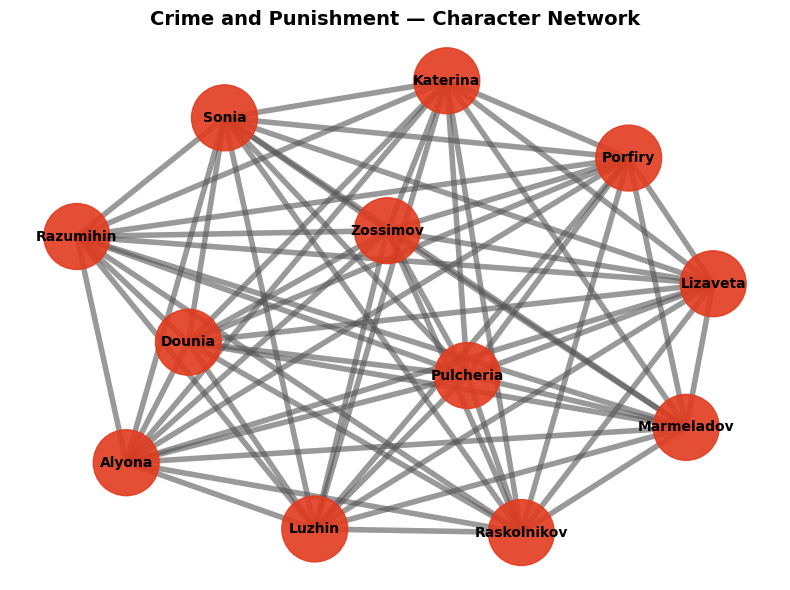

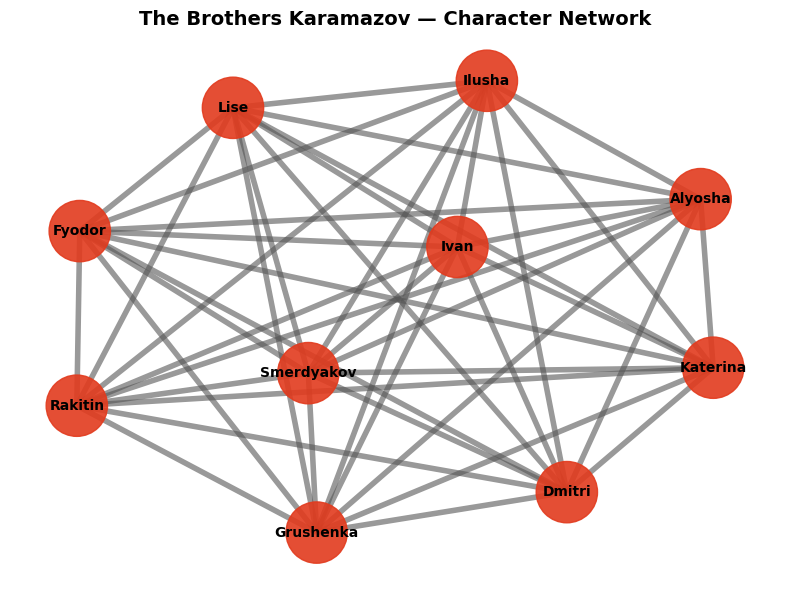

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_character_graph(G, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42)

    # Edge weights for line thickness
    weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
    max_w = max(weights) if weights else 1
    edge_widths = [1 + 3 * (w / max_w) for w in weights]

    # Node sizes proportional to degree (connections)
    node_sizes = [600 + 150 * G.degree(n) for n in G.nodes()]

    # Draw
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="#e23b1e", alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="#555555", alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- visualize both graphs ---
visualize_character_graph(G_cnp_chars, "Crime and Punishment — Character Network")
visualize_character_graph(G_bk_chars, "The Brothers Karamazov — Character Network")
